# Laboratory 4: Detect activities

In [568]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

In [569]:
# Plot settings
cm = plt.get_cmap('gist_rainbow')
line_styles = ['solid', 'dashed', 'dotted']

In [570]:
# Functions
def generateDF(filedir, colnames, sensors, patients, activities, slices):
    # get the data from files for the selected patients
    # and selected activities
    # concatenate all the slices
    # generate a pandas dataframe with an added column: activity
    x = pd.DataFrame()
    for pat in patients:
        for a in activities:
            subdir = 'a' + f"{a:02d}" + '/p' + str(pat) + '/'
            for s in slices:
                filename = filedir + subdir + 's' + f"{s:02d}" + '.txt'
                x1 = pd.read_csv(filename, usecols=sensors, names=colnames)
                # This is to set, for the whole slice, the activity number
                x1['activity'] = a * np.ones((x1.shape[0],), dtype=int)
                x = pd.concat([x, x1], axis=0, join='outer', ignore_index=True,
                              keys=None, levels=None, names=None, verify_integrity=False,
                              sort=False, copy=True)
    return x


def genFeatures(x, N):
    # the input is the output of generateDF (including the activity name)
    act = x.activity[0]
    y = x.drop(columns=['activity'])
    cols0 = y.columns
    cols1 = cols0 + '_mean'
    cols2 = cols0 + '_std'
    y = y.values  # get the values of dataFrame x
    Nin = y.shape[0]  # number of points in the input dataframe
    # N is the windows size, so we will have Nin - N valid points
    # In fact, the valid points are Nin - N + 1, but the last point of the window
    #   is computed manually
    Nout = Nin - N  # number of valid points in the output dataframe
    yav_m = np.zeros((Nin, y.shape[1]))
    yav_std = np.zeros((Nin, y.shape[1]))
    for k in range(Nout):
        temp = y[k:k + N, :]  # get the k-th window with N samples
        yav_m[k + N, :] = np.mean(temp, axis=0)
        yav_std[k + N, :] = np.std(temp, axis=0)
    # First N elements are removed, since they're not averaged
    yav_m = yav_m[N:, :]
    yav_std = yav_std[N:, :]
    outm_df = pd.DataFrame(yav_m, columns=cols1)
    outs_df = pd.DataFrame(yav_std, columns=cols2)
    out_a = pd.DataFrame(act * np.ones((Nout, 1)), columns=['activity'])
    out_df = pd.concat([outm_df, outs_df, out_a], axis=1)
    return out_df

In [571]:
# Data initialization
filedir = './data/'
sensNames = [
    'T_xacc', 'T_yacc', 'T_zacc',
    'T_xgyro', 'T_ygyro', 'T_zgyro',
    'T_xmag', 'T_ymag', 'T_zmag',
    'RA_xacc', 'RA_yacc', 'RA_zacc',
    'RA_xgyro', 'RA_ygyro', 'RA_zgyro',
    'RA_xmag', 'RA_ymag', 'RA_zmag',
    'LA_xacc', 'LA_yacc', 'LA_zacc',
    'LA_xgyro', 'LA_ygyro', 'LA_zgyro',
    'LA_xmag', 'LA_ymag', 'LA_zmag',
    'RL_xacc', 'RL_yacc', 'RL_zacc',
    'RL_xgyro', 'RL_ygyro', 'RL_zgyro',
    'RL_xmag', 'RL_ymag', 'RL_zmag',
    'LL_xacc', 'LL_yacc', 'LL_zacc',
    'LL_xgyro', 'LL_ygyro', 'LL_zgyro',
    'LL_xmag', 'LL_ymag', 'LL_zmag']
actNames = [
    'sitting',  # 1
    'standing',  # 2
    'lying on back',  # 3
    'lying on right side',  # 4
    'ascending stairs',  # 5
    'descending stairs',  # 6
    'standing in an elevator still',  # 7
    'moving around in an elevator',  # 8
    'walking in a parking lot',  # 9
    'walking on a treadmill with a speed of 4 km/h in flat',  # 10
    'walking on a treadmill with a speed of 4 km/h in 15 deg inclined position',  # 11
    'running on a treadmill with a speed of 8 km/h',  # 12
    'exercising on a stepper',  # 13
    'exercising on a cross trainer',  # 14
    'cycling on an exercise bike in horizontal positions',  # 15
    'cycling on an exercise bike in vertical positions',  # 16
    'rowing',  # 17
    'jumping',  # 18
    'playing basketball'  # 19
]
actNamesShort = [
    'sitting',  # 1
    'standing',  # 2
    'lying.ba',  # 3
    'lying.ri',  # 4
    'asc.sta',  # 5
    'desc.sta',  # 6
    'stand.elev',  # 7
    'mov.elev',  # 8
    'walk.park',  # 9
    'walk.4.fl',  # 10
    'walk.4.15',  # 11
    'run.8',  # 12
    'exer.step',  # 13
    'exer.train',  # 14
    'cycl.hor',  # 15
    'cycl.ver',  # 16
    'rowing',  # 17
    'jumping',  # 18
    'play.bb'  # 19
]

In [572]:
# Sensors used
use_acc = True
use_mag = True
use_gyr = False
# Body regions
on_LL = True
on_RL = False
on_T = False
on_LA = False
on_RA = False

In [573]:
# Indices generation for each sensor
# Types
ind_acc = [i for i in range(45) if 'acc' in sensNames[i]]  # accelerometers
ind_mag = [i for i in range(45) if 'mag' in sensNames[i]]  # magnetometers
ind_gyr = [i for i in range(45) if 'gyr' in sensNames[i]]  # gyroscopes
# sensors1 = ind_acc + ind_mag + ind_gyr
# Selected sensor types
sensors1 = []
if use_acc:
    sensors1 += ind_acc
if use_mag:
    sensors1 += ind_mag
if use_gyr:
    sensors1 += ind_gyr
# On the body
sensorsT = [i for i in sensors1 if 'T' in sensNames[i]]  # sensors on torso
sensorsLL = [i for i in sensors1 if 'LL' in sensNames[i]]  # sensors on left leg
sensorsLA = [i for i in sensors1 if 'LA' in sensNames[i]]  # sensors on left arm
sensorsRL = [i for i in sensors1 if 'RL' in sensNames[i]]  # sensors on right leg
sensorsRA = [i for i in sensors1 if 'RA' in sensNames[i]]  # sensors on right arm
# sensors = sensorsLL
# Selected body regions
sensors = []
if on_LL:
    sensors += sensorsLL
if on_RL:
    sensors += sensorsRL
if on_T:
    sensors += sensorsT
if on_LA:
    sensors += sensorsLA
if on_RA:
    sensors += sensorsRA

In [574]:
Nslices = 25  # number of slices to plot and to train the system
memory_factor = 8  # factor to be multiplied to the number of sampled per second

In [575]:
# Available data settings
patients = [5]  # list of selected patients
NAc = 19  # total number of activities
activities = list(range(1, 20))  # list of indexes of activities to plot
actNamesSub = [actNamesShort[i - 1] for i in activities]  # short names of the selected activities
sensNamesSub = [sensNames[i] for i in sensors]  # names of selected sensors
# Slices are portions of data taken, which in this case is memorized in single .txt files
slices = list(range(1, Nslices + 1))  # first Nslices to plot
NtotSlices = 60  # total number of slices
fs = 25  # Hz, sampling frequency
# 25 samples are taken in one single second
samplesPerSecond = fs  # samples in one second
# Each slice contains samples taken for 5 seconds
samplesPerSlice = fs * 5  # samples in each slice
# memory = 8 * samplesPerSecond
memory = memory_factor * samplesPerSecond

In [576]:
save_plots = False
if save_plots:
    for i in activities:
        activ = [i]
        x = generateDF(filedir, sensNamesSub, sensors, patients, activ, slices)
        x = genFeatures(x, memory)
        x = x.drop(columns=['activity'])
        sensor_names = list(x.columns)
        data = x.values
        plt.figure(figsize=(6, 6))
        time = np.arange(data.shape[0]) / fs  # set the time axis
        for k in range(len(sensor_names)):
            lines = plt.plot(time, data[:, k], '.', label=sensor_names[k], markersize=1)
            lines[0].set_color(cm(k // 3 * 3 / len(sensor_names)))
            lines[0].set_linestyle(line_styles[k % 3])
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
        plt.grid()
        plt.xlabel('time (s)')
        plt.tight_layout()
        plt.title(actNames[i - 1])
        plt.subplots_adjust(top=0.9)
        plt.savefig('./Plot_' + actNamesSub[i - 1] + '.png')

Number of used sensors:  6
           LL_xacc      LL_yacc      LL_zacc      LL_xmag      LL_ymag  \
count  3125.000000  3125.000000  3125.000000  3125.000000  3125.000000   
mean     -2.965270    -9.315026    -1.329947    -0.181600     0.716305   
std       0.017665     0.011539     0.018024     0.000732     0.000767   
min      -3.032000    -9.380900    -1.388100    -0.184420     0.713640   
25%      -2.972500    -9.321700    -1.343300    -0.182110     0.715790   
50%      -2.964700    -9.313700    -1.329000    -0.181600     0.716330   
75%      -2.957200    -9.313400    -1.314300    -0.181090     0.716860   
max      -2.882300    -9.269000    -1.239500    -0.178750     0.719180   

           LL_zmag  activity  
count  3125.000000    3125.0  
mean      0.288557       1.0  
std       0.001154       0.0  
min       0.285030       1.0  
25%       0.287840       1.0  
50%       0.288720       1.0  
75%       0.289390       1.0  
max       0.291790       1.0  
           LL_xacc      LL_

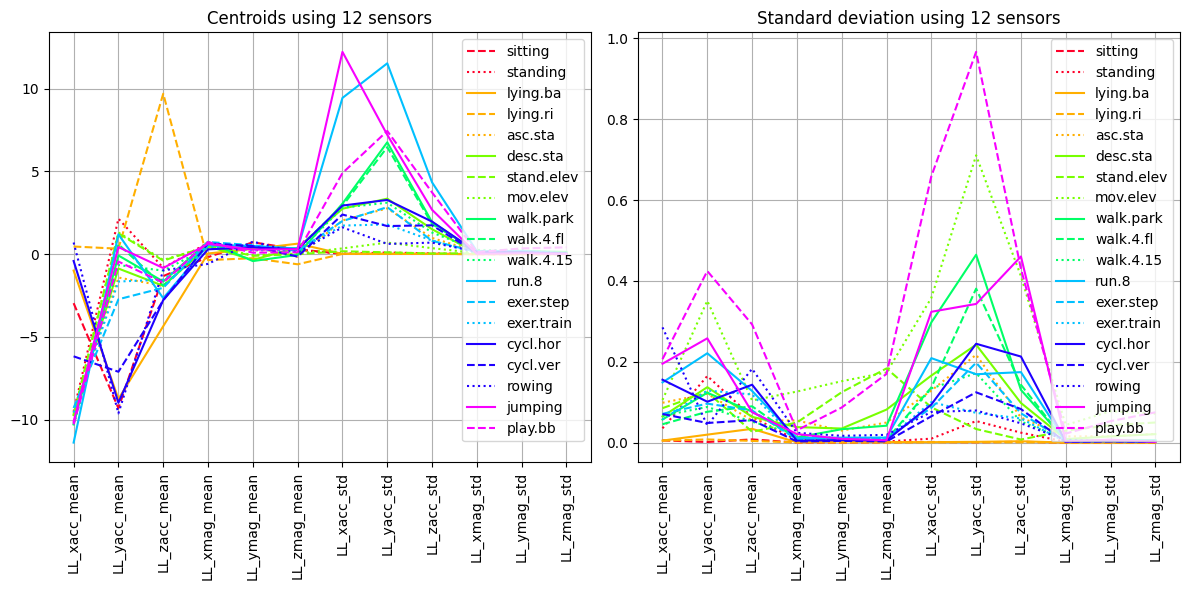

In [577]:
# Centroids generation
plot_results = True
print('Number of used sensors: ', len(sensors))
centroids = np.zeros((NAc, len(sensors) * 2))  # centroids for all the activities
stdpoints = np.zeros((NAc, len(sensors) * 2))  # variance in cluster for each sensor
if plot_results:
    plt.figure(figsize=(12, 6))
sensor_names = []
x = pd.DataFrame()
for i in range(1, NAc + 1):
    activ = [i]
    x = generateDF(filedir, sensNamesSub, sensors, patients, activ, slices)
    print(x.describe())
    x = genFeatures(x, memory)
    x = x.drop(columns=['activity'])
    sensor_names = list(x.columns)
    centroids[i - 1, :] = x.mean().values
    stdpoints[i - 1] = np.sqrt(x.var().values)
    if plot_results:
        plt.subplot(1, 2, 1)
        lines = plt.plot(centroids[i - 1, :], label=actNamesShort[i - 1])
        lines[0].set_color(cm(i // 3 * 3 / NAc))
        lines[0].set_linestyle(line_styles[i % 3])
        plt.subplot(1, 2, 2)
        lines = plt.plot(stdpoints[i - 1, :], label=actNamesShort[i - 1])
        lines[0].set_color(cm(i // 3 * 3 / NAc))
        lines[0].set_linestyle(line_styles[i % 3])
if plot_results:
    plt.subplot(1, 2, 1)
    plt.legend(loc='upper right')
    plt.grid()
    plt.title('Centroids using ' + str(len(sensor_names)) + ' sensors')
    plt.xticks(np.arange(x.shape[1]), list(x.columns), rotation=90)
    plt.subplot(1, 2, 2)
    plt.legend(loc='upper right')
    plt.grid()
    plt.title('Standard deviation using ' + str(len(sensor_names)) + ' sensors')
    plt.xticks(np.arange(x.shape[1]), list(x.columns), rotation=90)
    plt.tight_layout()

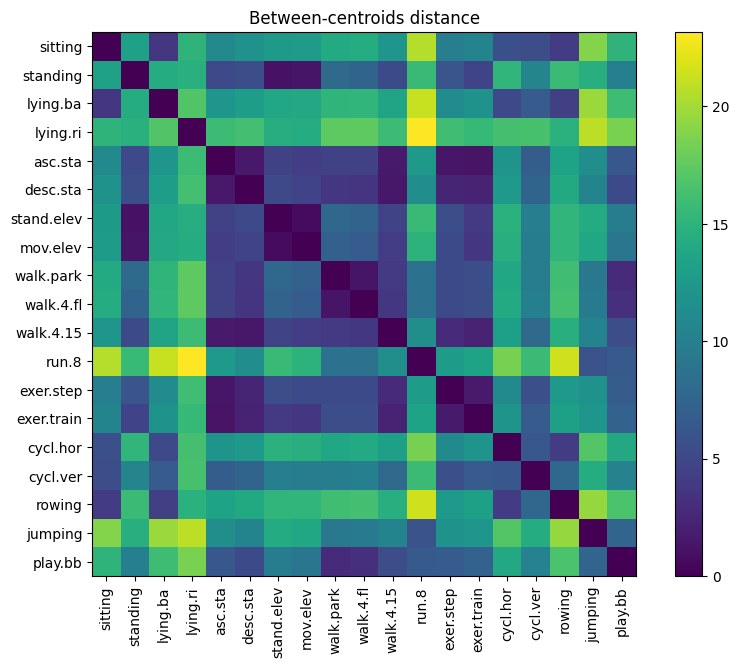

In [578]:
# Computing distances between centroids
plot_results = True
d = np.zeros((NAc, NAc))
for i in range(NAc):
    for j in range(NAc):
        d[i, j] = np.linalg.norm(centroids[i] - centroids[j])
if plot_results:
    plt.figure(figsize=(10, 8))
    plt.matshow(d, fignum=0)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar()
    plt.xticks(np.arange(NAc), actNamesShort, rotation=90)
    plt.yticks(np.arange(NAc), actNamesShort)
    plt.subplots_adjust(bottom=0.2)
    plt.title('Between-centroids distance')

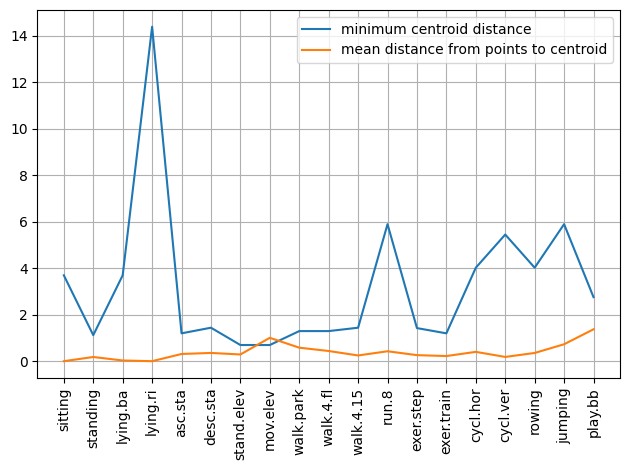

In [579]:
# Comparing minimum distance between two centroids and mean distance from a cluster point
# and its centroid
dd = d + np.eye(NAc) * 1e6  # remove zeros on the diagonal (distance of centroid from itself)
dmin = dd.min(axis=0)  # find the minimum distance for each centroid
dpoints = np.sqrt(np.sum(stdpoints ** 2, axis=1))
plt.figure()
plt.plot(dmin, label='minimum centroid distance')
plt.plot(dpoints, label='mean distance from points to centroid')
plt.grid()
plt.xticks(np.arange(NAc), actNamesShort, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()
# if the minimum distance is less than the mean distance, then some points of the cluster are closer 
# to another centroid

In [580]:
# Generating the training and test datasets by concatenating data for each activity
slicesTrain = list(range(1, Nslices + 1))  # slices for the training part
slicesTest = list(range(Nslices + 1, NtotSlices + 1))  # first for the test part
Ntrain = Nslices * samplesPerSlice
Ntest = (NtotSlices - Nslices) * samplesPerSlice
dataTrain = np.empty((0, len(sensors) * 2), float)
dataTest = np.empty((0, len(sensors) * 2), float)
labelTrain = np.empty((0,), float)
labelTest = np.empty((0,), float)
for i in range(1, NAc + 1):
    activ = [i]
    x = generateDF(filedir, sensNamesSub, sensors, patients, activ, slicesTrain)
    x = genFeatures(x, memory)
    labels = x.activity.values
    x = x.drop(columns=['activity'])
    data = x.values
    dataTrain = np.vstack((dataTrain, data))
    labelTrain = np.hstack((labelTrain, labels))
    x = generateDF(filedir, sensNamesSub, sensors, patients, activ, slicesTest)
    x = genFeatures(x, memory)
    labels = x.activity.values
    x = x.drop(columns=['activity'])
    data = x.values
    dataTest = np.vstack((dataTest, data))
    labelTest = np.hstack((labelTest, labels))

In [581]:
# Using K-Means
labsTrue = np.unique(labelTrain)
Nclu = len(labsTrue)
clu = KMeans(n_clusters=Nclu, init='k-means++', n_init=10,
             max_iter=300, tol=0.0001, verbose=0,
             random_state=1, copy_x=True)
clu.fit(dataTrain)

KMeans(n_clusters=19, n_init=10, random_state=1)

In [582]:
# Prediction
labCluTrain = clu.labels_
labsClu = np.unique(labCluTrain)
labCluTest = clu.predict(dataTest)

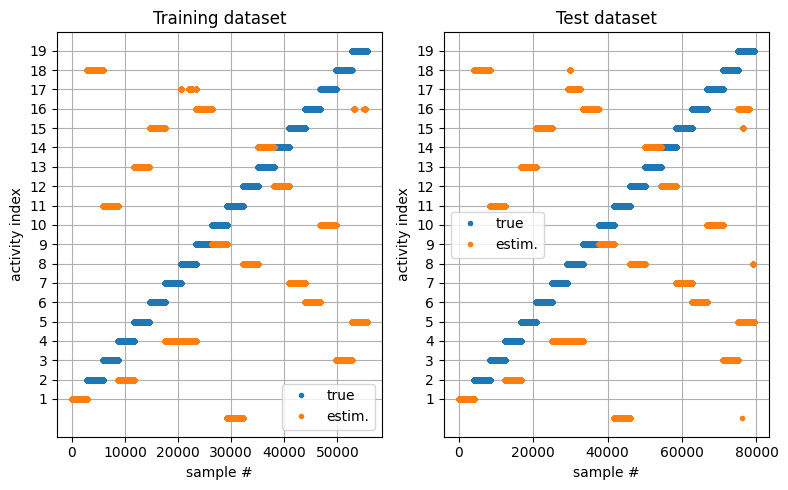

In [583]:
# Plotting results
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.yticks(activities)
plt.plot(labelTrain, '.', label='true')
plt.plot(labCluTrain, '.', label='estim.')
plt.title('Training dataset')
plt.legend()
plt.grid()
plt.xlabel('sample #')
plt.ylabel('activity index')
plt.subplot(1, 2, 2)
plt.yticks(activities)
plt.plot(labelTest, '.', label='true')
plt.plot(labCluTest, '.', label='estim.')
plt.title('Test dataset')
plt.legend()
plt.grid()
plt.xlabel('sample #')
plt.ylabel('activity index')
plt.tight_layout()
plt.show()

### Labels correction
The clustering results of *K-Means* are based on *arbitrary labels*, so it is reasonable that they could not be coherent with the true labels given by the real data. It consequently makes sense to adjust the results trying to make them fit with the true labels with a *reassignment*.
##### Method
The method used tries to build a new mapping for the clusters $\^C$ found by K-Means.
For each cluster $\^c_i \in \^C$, counts the labels occurrences on the initial mapping for the clusters $C$ for each element of the cluster $\^c_i$, and maps $\^c_i$ to the label with the maximum number of occurrence with the initial mapping.

In [584]:
def adjust_labels(y, y_hat):
    predict_unique = np.unique(y_hat)  # takes all the clusters
    mapping = {}
    for clu in predict_unique:  # for each cluster
        true_labels = y[np.argwhere(y_hat == clu)]  # finds the true labels for each element of the cluster
        count_occ = np.unique(true_labels, return_counts=True)  # counts the occurrences
        mapping[clu] = count_occ[0][np.argmax(count_occ[
                                                  1])]  # takes the label associated to the true cluster with maximum occurrences with the current cluster
    # builds the new mapping
    res = np.copy(y_hat)
    for k in mapping.keys():
        res[y_hat == k] = mapping[k]
    return res

In [585]:
# Adjusting K-Means index results
labCluTest_fix = adjust_labels(labelTest, labCluTest)
labCluTrain_fix = adjust_labels(labelTrain, labCluTrain)

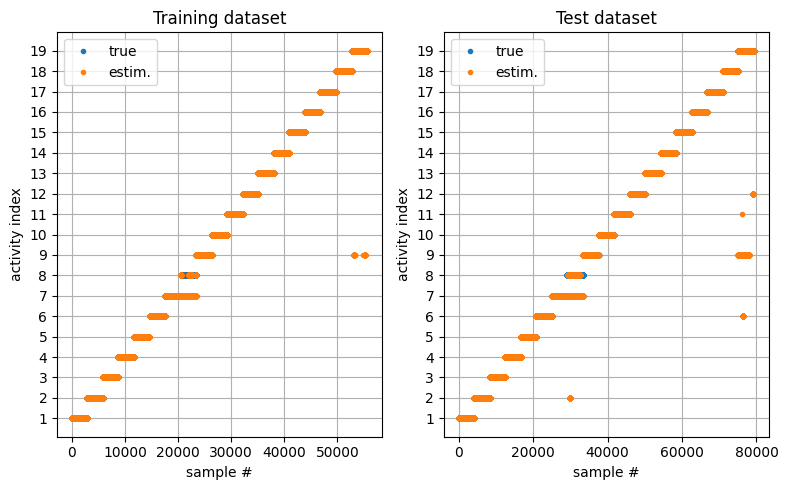

In [586]:
# Plotting adjusted results
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.yticks(activities)
plt.plot(labelTrain, '.', label='true')
plt.plot(labCluTrain_fix, '.', label='estim.')
plt.title('Training dataset')
plt.legend()
plt.grid()
plt.xlabel('sample #')
plt.ylabel('activity index')
plt.subplot(1, 2, 2)
plt.yticks(activities)
plt.plot(labelTest, '.', label='true')
plt.plot(labCluTest_fix, '.', label='estim.')
plt.title('Test dataset')
plt.legend()
plt.grid()
plt.xlabel('sample #')
plt.ylabel('activity index')
plt.tight_layout()
plt.show()

The labels of the clusters found are adjusted all together, consequently the elements that are clustered wrongly will be labeled together with the correct ones. This explains the various sparse elements.

### Confusion matrix
The *confusion matrix* $K \in \mathbb{R}^{LxL}$ ($L$ is the number of clusters) is built so that the element $K_{ij} = P(i|j)$.
$P(i|j)$ means "probability that the detected activity is $i$ given that the true activity is $j$".

In [587]:
# Training dataset section
K_tr = np.empty(shape=(NAc, NAc))
for j in range(NAc):  # rows
    activ_j = j + 1
    elem_j = np.argwhere(labelTrain == activ_j)
    N_j = len(elem_j)
    predict_elem = np.unique(labCluTrain_fix[elem_j], return_counts=True)
    for i in range(NAc):  # columns
        activ_i = i + 1
        N_i = 0
        if activ_i in predict_elem[0]:
            N_i = predict_elem[1][np.argwhere(predict_elem[0] == activ_i).flatten()[0]]
        K_tr[j, i] = N_i / N_j

In [588]:
# Test dataset section
K_te = np.empty(shape=(NAc, NAc))
for j in range(NAc):  # rows
    activ_j = j + 1
    elem_j = np.argwhere(labelTest == activ_j)
    N_j = len(elem_j)
    predict_elem = np.unique(labCluTest_fix[elem_j], return_counts=True)
    for i in range(NAc):  # columns
        activ_i = i + 1
        N_i = 0
        if activ_i in predict_elem[0]:
            N_i = predict_elem[1][np.argwhere(predict_elem[0] == activ_i).flatten()[0]]
        K_te[j, i] = N_i / N_j

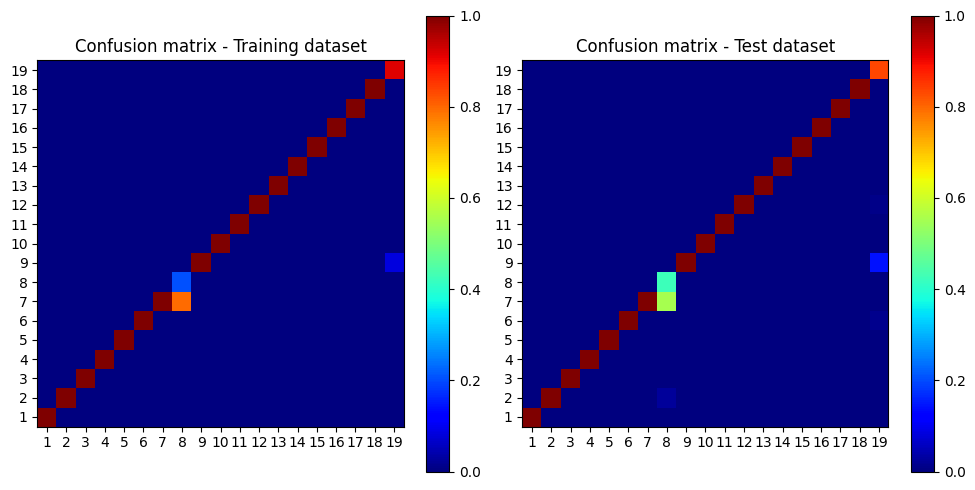

In [589]:
# Printing the confusion matrix
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.matshow(np.rot90(K_tr), cmap='jet', fignum=0)
plt.gca().xaxis.tick_bottom()
plt.xticks(np.arange(NAc), activities, rotation=0)
plt.yticks(np.arange(NAc)[::-1], activities, rotation=0)
plt.colorbar()
plt.title('Confusion matrix - Training dataset')
plt.tight_layout()
plt.subplot(1, 2, 2)
plt.matshow(np.rot90(K_te), cmap='jet', fignum=0)
plt.gca().xaxis.tick_bottom()
plt.xticks(np.arange(NAc), activities, rotation=0)
plt.yticks(np.arange(NAc)[::-1], activities, rotation=0)
plt.colorbar()
plt.title('Confusion matrix - Test dataset')
plt.tight_layout()
plt.show()

These results show that the activity 8, associated with **moving on an elevator**, is not always correctly detected in both training and test sets. It is mostly confused with just **standing on an elevator** (activity 7). This can be explained by the fact that the accelerometers are "confused" by the dummy force generated by the elevator, which causes an acceleration.

### Accuracy
The *accuracy* is computed using $Acc = \sum_{i = 1}^{L}{P(i|i)P(i)}$, with $P(i) = \frac{1}{L}$.
It can also be computed by summing the elements on the diagonal of the *confusion matrix* $K$: $Acc = \frac{1}{L}\sum_{i = 1}^{L}{K_{ii}}$.

In [590]:
# Training dataset section
acc_tr = np.sum(np.diagonal(K_tr)) / NAc

In [591]:
# Test dataset section
acc_te = np.sum(np.diagonal(K_te)) / NAc

In [592]:
print(f'Accuracy for the training dataset: {acc_tr * 100: .2f}%')
print(f'Accuracy for the test dataset: {acc_te * 100: .2f}%')

Accuracy for the training dataset:  95.36%
Accuracy for the test dataset:  96.09%


### Accuracy for each activity
The accuracy of each single activity $i$ correspond to the element $K_{ii}$ of the *confusion matrix* $K$.

In [593]:
e_act_tr = 1 - np.diagonal(K_tr)
e_act_te = 1 - np.diagonal(K_te)

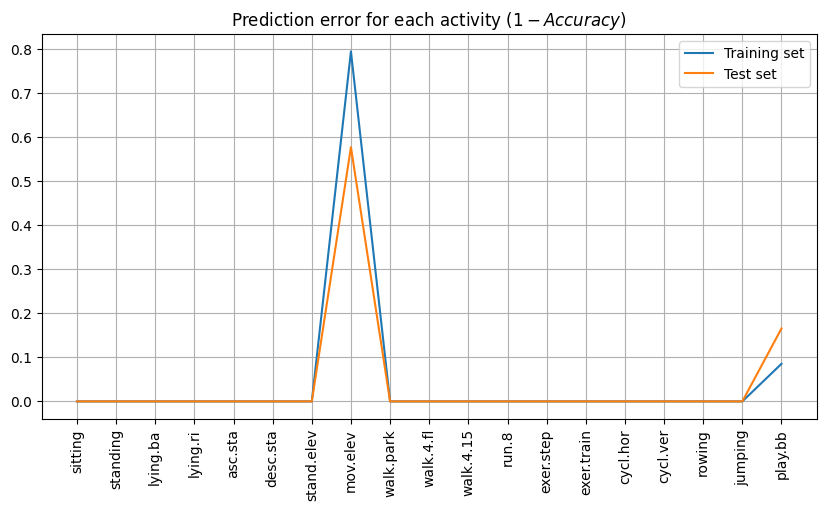

In [594]:
plt.figure(figsize=(10, 5))
plt.grid()
plt.plot(e_act_tr)
plt.plot(e_act_te)
labels = ['Training set', 'Test set']
plt.legend(labels)
plt.xticks(np.arange(NAc), actNamesShort, rotation=90)
plt.title('Prediction error for each activity ($1 - Accuracy$)')
plt.show()

### Comments on the results
##### Data pre-processing
The parameters that showed a good response are a number of slices set to 25 and a memory size of 8 times the sampling frequency.
##### Sensors used   
With different many tries, the configuration found that appears more "suitable" for the activity detection is the one with an *accelerometer* and a *magnetometer* placed on the *left leg*, with an accuracy of **96%** on the test set. While it hardly detect if a person is **moving on an elevator**, it allows to correctly detect most of the activities without having a lot of sensors involved, which makes the configuration user-friendly.
The two activities that are confused the most are **standing** and **moving around** in an elevator.
Also, **basketball** is not always correctly detected, possibly due to its very variable movements.
A minimalist configuration involves just the *accelerometer* installed on the *left leg*, giving an overall accuracy of 91% but without detecting when the user is *walking on a treadmill*, assuming it is *walking in a parking lot*.